# SED Recovery

In this section, we will discuss the process of recovering the spectral energy distribution (SED) of astronomical sources using the models generated in the previous sections. This will only work if you have a trained inference model, which can be obtained by following the inference tutorial.


For most models created by Synference using Synthesizer, information about the simulator used to generate the model grid is stored in the HDF5 file (e.g. the SPS grid, SFH and metallicity models, emission model, etc). This allows Synference to automatically reconstruct the simulator to generate SEDs for any set of parameters sampled from the posterior distribution.

First we will load in a trained inference model and the corresponding fitter object used to generate the model library. 

Note that the manual recreation of the noise model here is only neccessary to get this to work in the documentation. In practice, the noise model should be loaded directly if the path to exists.


You will also need to have the correct model grid (`bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps.hdf5`) available in your Synthesizer grid directory for this to work. You can download this from Box.

```python

In [16]:
from synthesizer import get_grids_dir
import os

print(get_grids_dir())

available_grids = os.listdir(get_grids_dir())
if 'test_grid.hdf5' not in available_grids:
    cmd = f'synthesizer-download --test-grids --destination {get_grids_dir()}'
    os.system(cmd)

grid_path = os.path.join(get_grids_dir(), 'test_grid.hdf5')

/Users/user/Library/Application Support/Synthesizer/grids


In [8]:
from synference import SBI_Fitter, load_unc_model_from_hdf5

grid_path = "../example_models/bpass_db_v4/grid_BPASS_Chab_DenseBasis_SFH_0.01_z_14_logN_2.7_Calzetti_v3_multinode.hdf5"  # noqa: E501

fitter = SBI_Fitter.load_saved_model(
    model_file="../example_models/bpass_db_v4", grid_path=grid_path, device="cpu"
)

nm_path = (
    "../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_params_empirical_noise_models.h5"
)
noise_models = load_unc_model_from_hdf5(nm_path)

fitter.feature_array_flags["empirical_noise_models"] = noise_models

2025-11-05 11:21:11,867 | synference | INFO     | Loaded model from ../example_models/bpass_db_v4/BPASS_DenseBasis_v4_final_nsf_0_posterior.pkl.
2025-11-05 11:21:11,867 | synference | INFO     | Device: cpu
2025-11-05 11:21:11,894 | synference | WARNING  | IndexError when trying to set train/test arrays. 


Now we can recreate the simulator.


In [19]:
fitter.recreate_simulator_from_grid(override_grid_path=grid_path);

Now let's get some mock photometry to recover the SEDs for. We will load a set of mock observations created using the same simulator as the model grid.

In [10]:
import numpy as np
from IPython.display import display

path = "../example_models/bpass_db_v4/sbi_test_data_BPASS_DenseBasis_v4_final.npz"
data = np.load(path)
X_test = data["X"]
y_test = data["y"]

Now we can use the `recover_SED` method of the inference model to recover the SEDs for our mock photometry. This method will sample from the posterior distribution and generate SEDs for each sample using the reconstructed simulator.


In [11]:
?fitter.recover_SED

Signature:
fitter.recover_SED(
    X_test: numpy.ndarray,
    samples: numpy.ndarray = None,
    num_samples=1000,
    sample_method: str = 'direct',
    sample_kwargs: dict = {},
    posteriors=None,
    simulator: <built-in function callable> = None,
    prior: object = None,
    plot: bool = True,
    marginalized_parameters: Dict[str, <built-in function callable>] = None,
    extra_parameters: Dict[str, float] = None,
    phot_unit='AB',
    true_parameters=[],
    plot_name=None,
    plots_dir='/Users/user/Documents/PhD/synference/models/name/plots/',
    sample_color='firebrick',
    param_labels=None,
    plot_closest_draw_to={},
    plot_sfh=True,
    plot_histograms=True,
    kde=True,
    save_plots=True,
    fig=None,
    ax=None,
    ax_sfh=None,
)
Docstring:
Recover the SED for a given observation, if a simulator is provided.

Parameters:
    X_test: The input observation to recover the SED for.
    samples: Samples from the posterior distribution.
        if None, samples

Now we will loop over the recovered SEDs and plot them.

Running simulator on samples:   0%|          | 0/100 [00:00<?, ?it/s]

2025-11-05 11:21:34,805 | synference | WARNING  | The following parameters are not used by the simulator: ['log10_Av', 'log_sfr', 'sfh_quantile_25', 'sfh_quantile_50', 'sfh_quantile_75', 'log10_mass_weighted_age', 'log10_floor_sfr_10', 'log_surviving_mass', 'beta', 'Av', 'mass_weighted_age', 'floor_sfr_10']


Running simulator on samples: 100%|██████████| 100/100 [00:15<00:00,  6.36it/s]


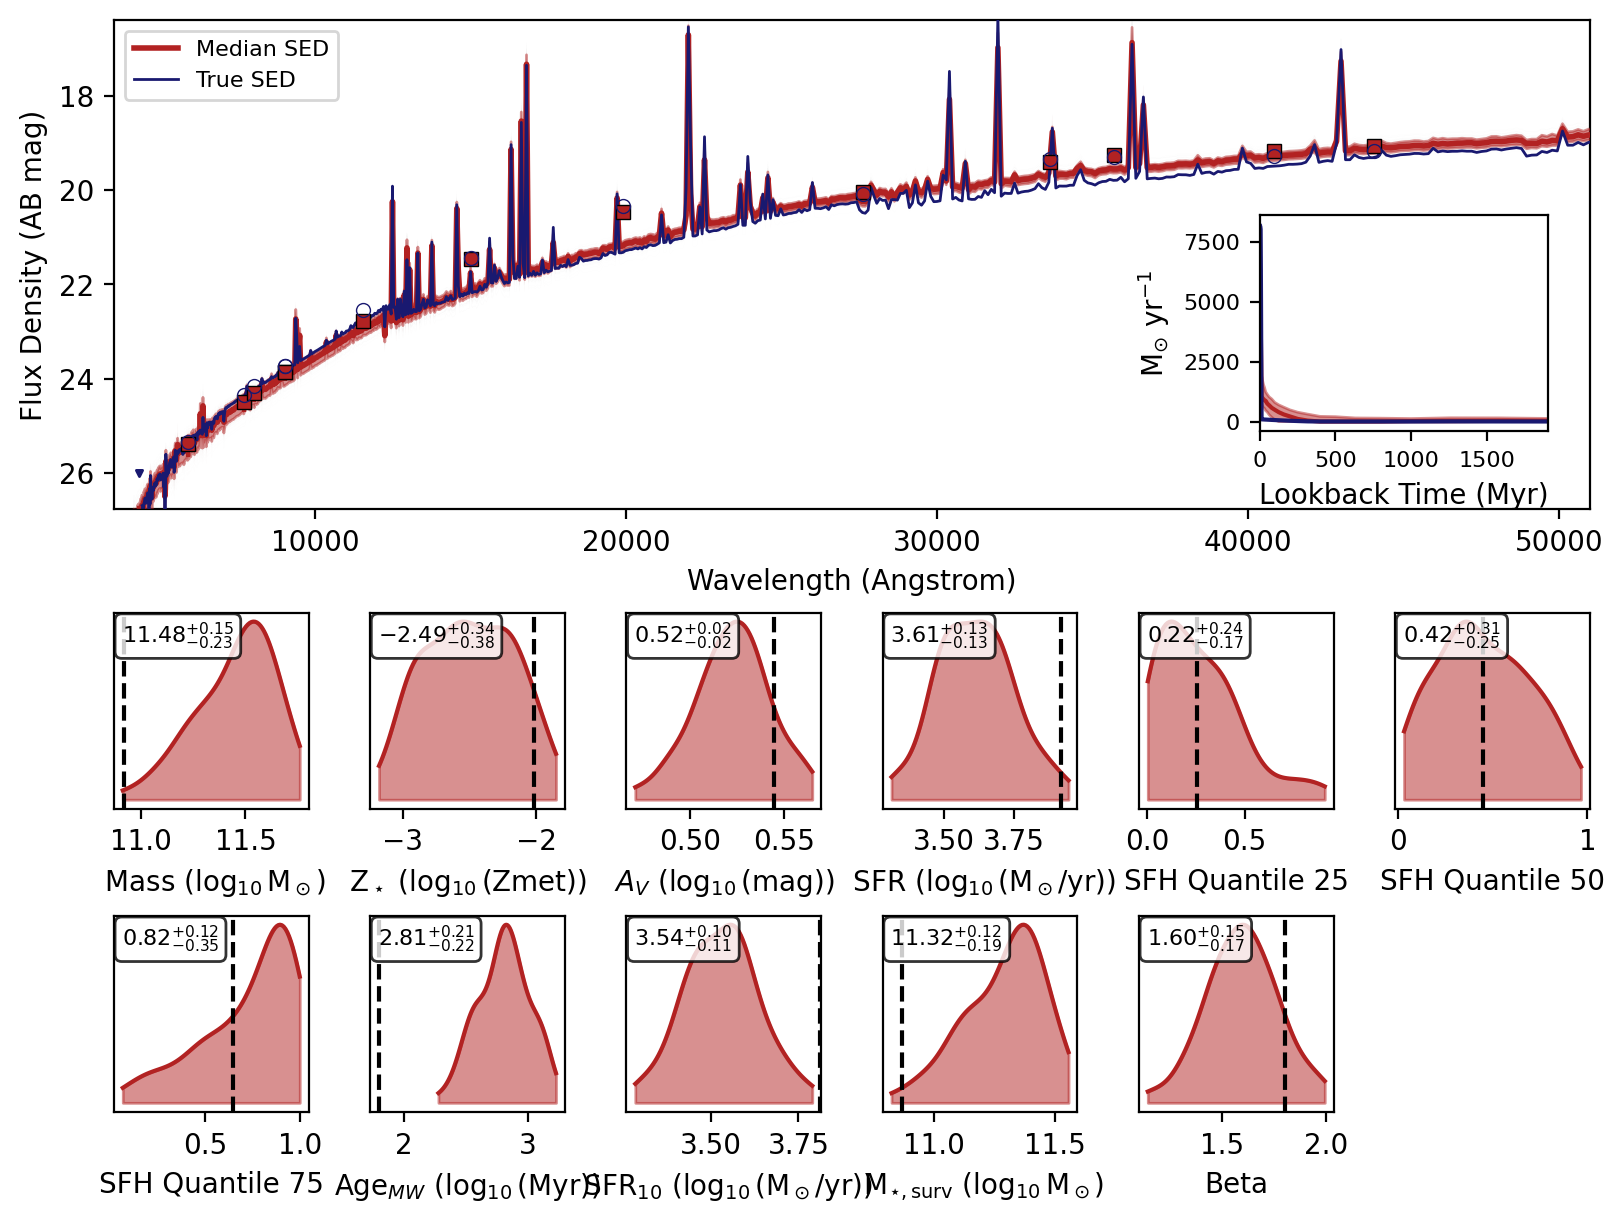

Running simulator on samples: 100%|██████████| 100/100 [00:10<00:00,  9.35it/s]


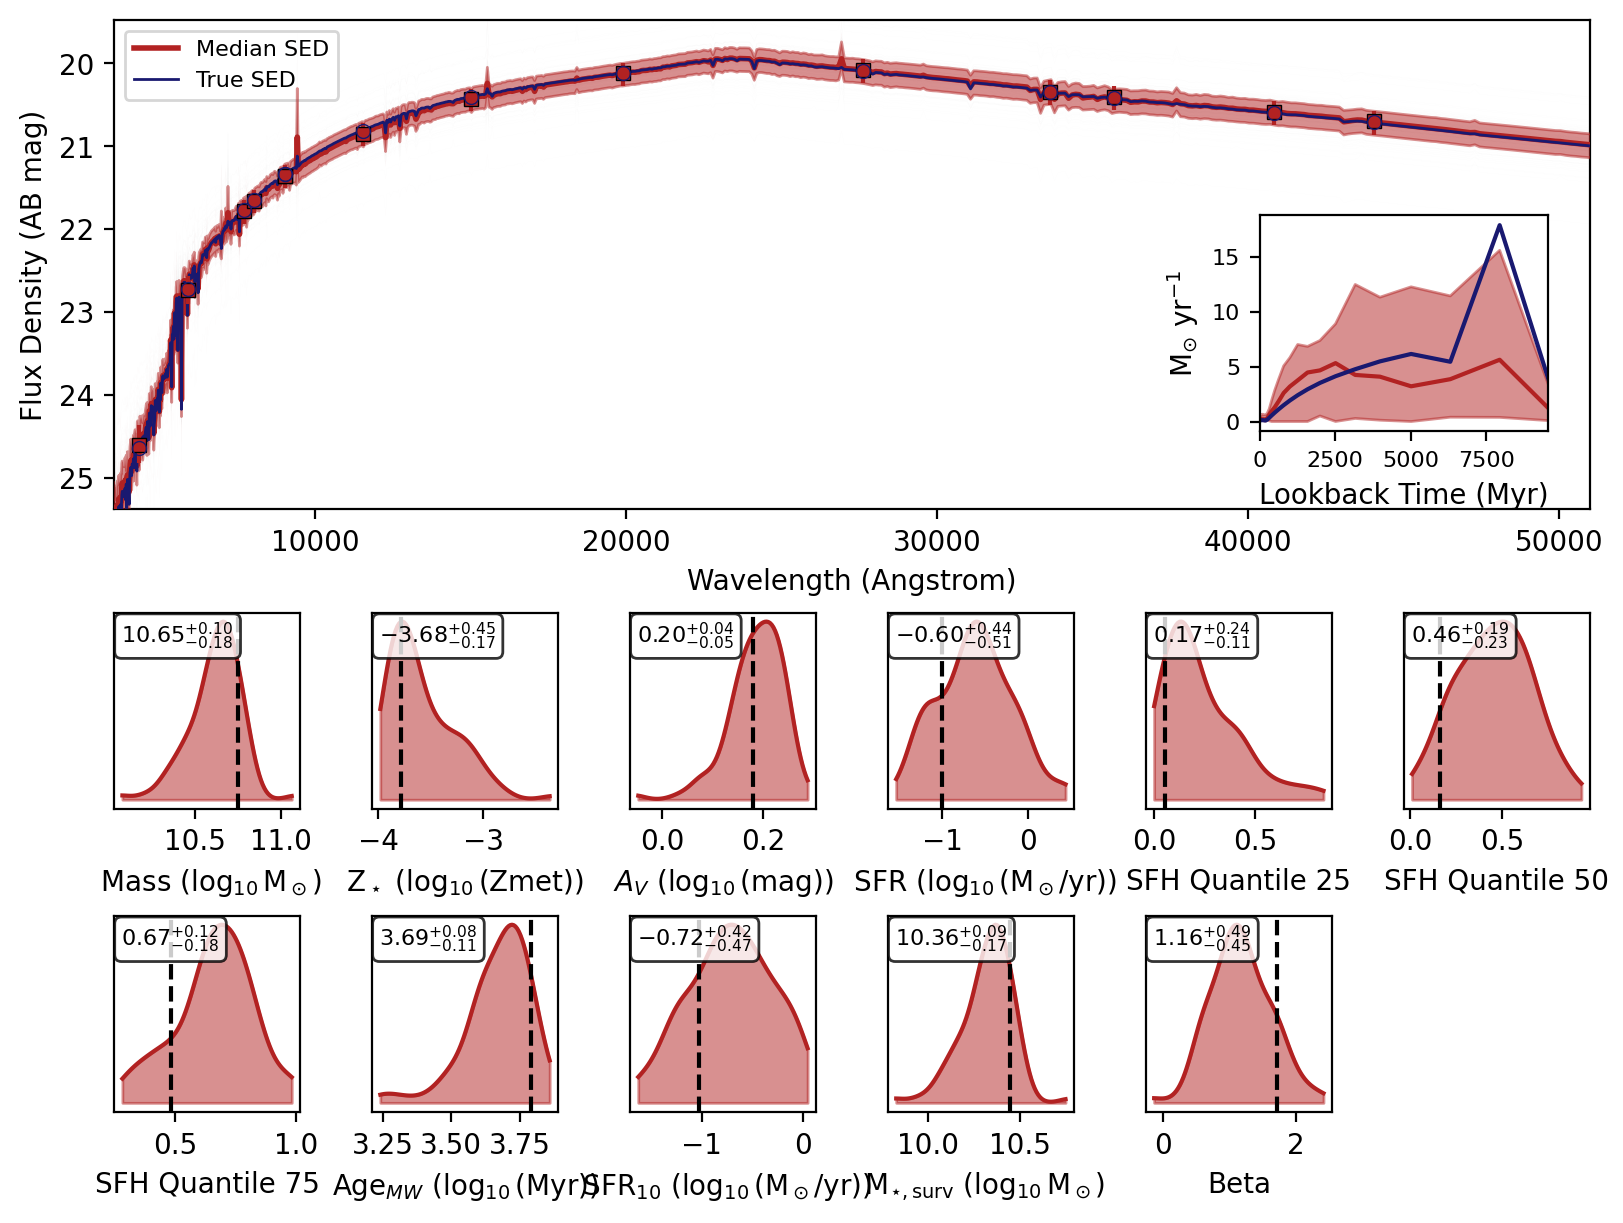

Running simulator on samples: 100%|██████████| 100/100 [00:09<00:00, 10.98it/s]


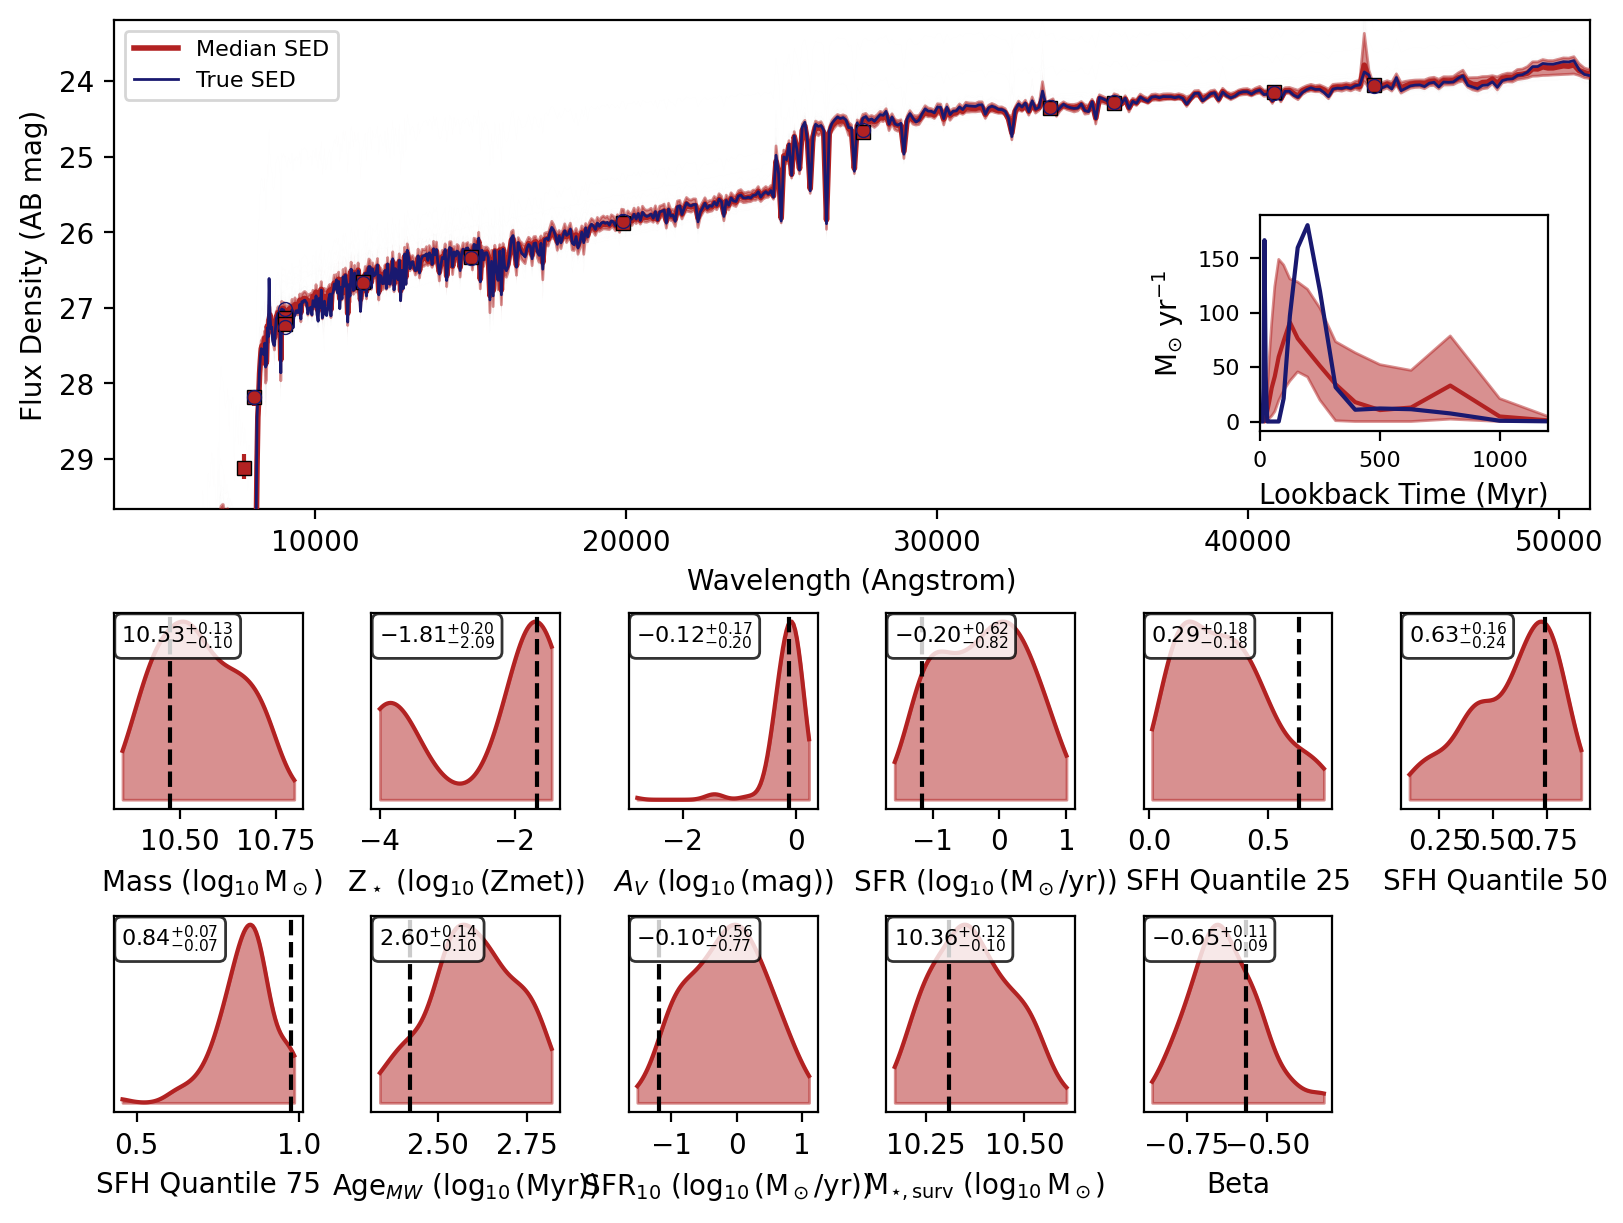

Running simulator on samples: 100%|██████████| 100/100 [00:09<00:00, 10.91it/s]


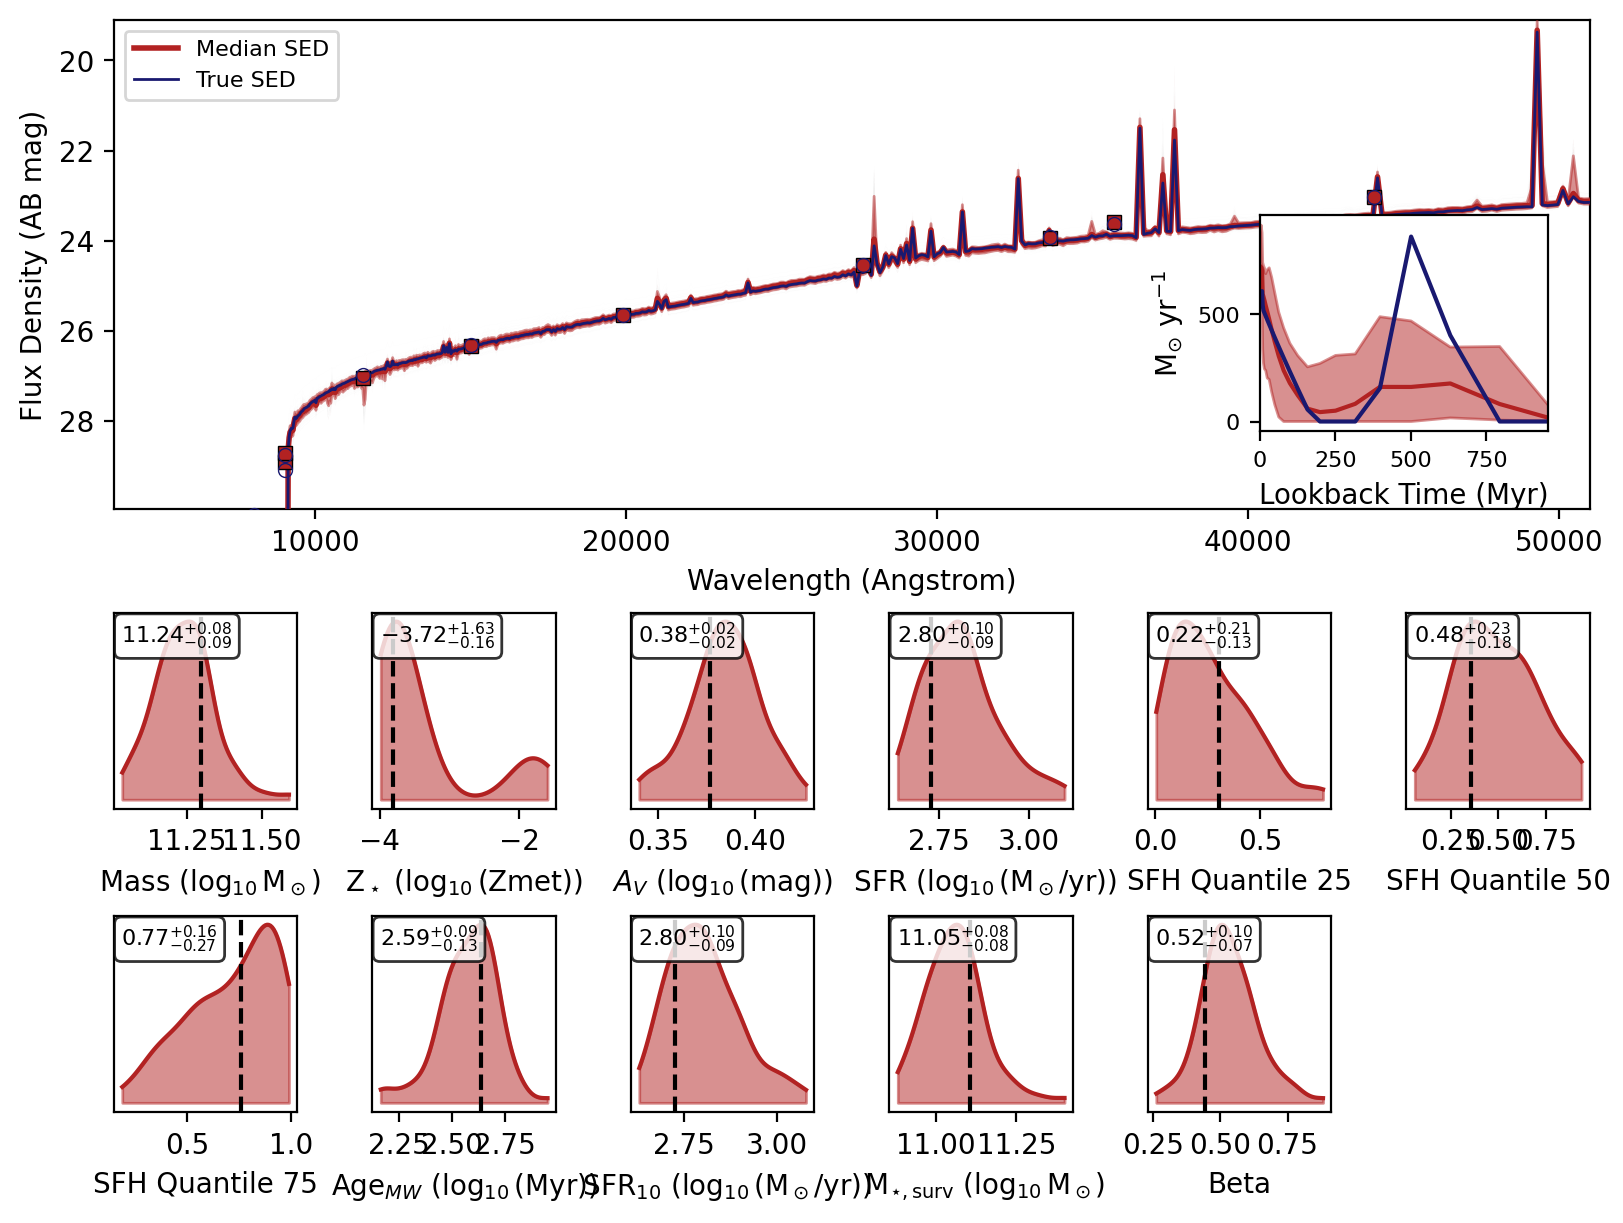

Running simulator on samples: 100%|██████████| 100/100 [00:07<00:00, 13.05it/s]


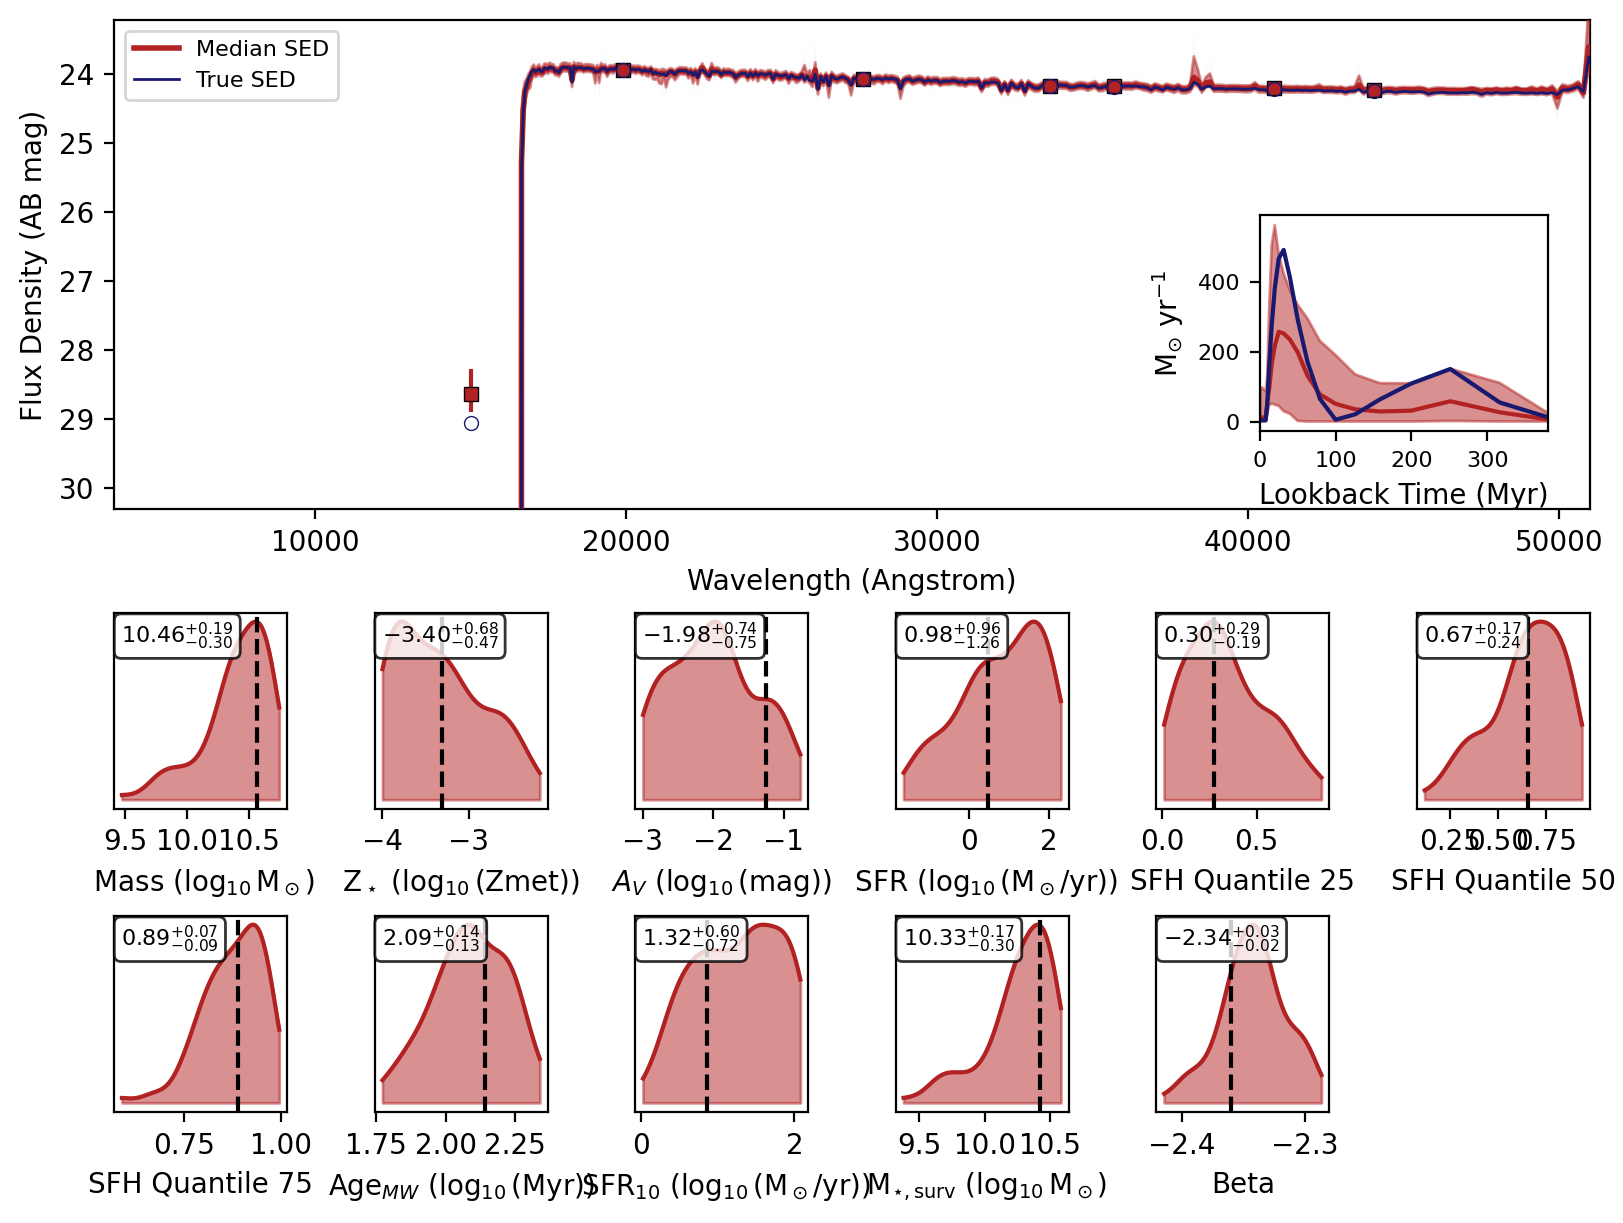

Running simulator on samples: 100%|██████████| 100/100 [00:09<00:00, 10.97it/s]


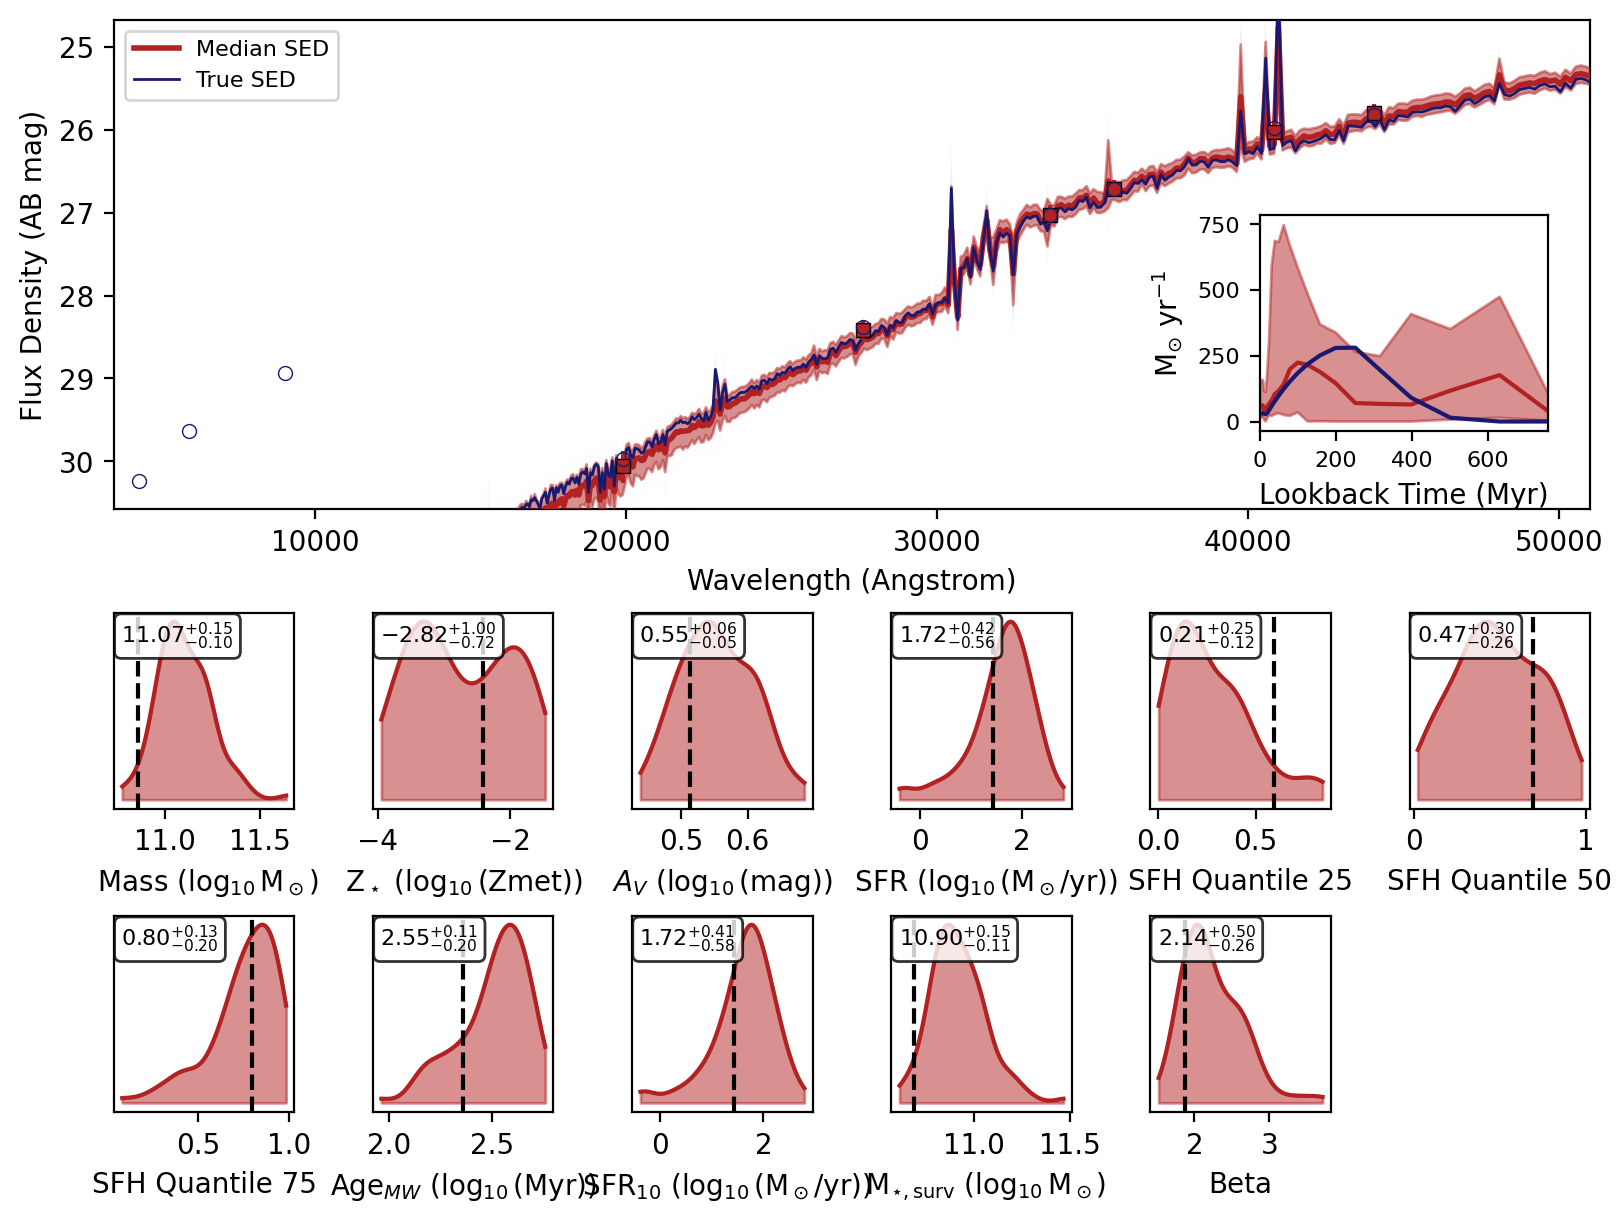

Running simulator on samples: 100%|██████████| 100/100 [00:10<00:00,  9.66it/s]


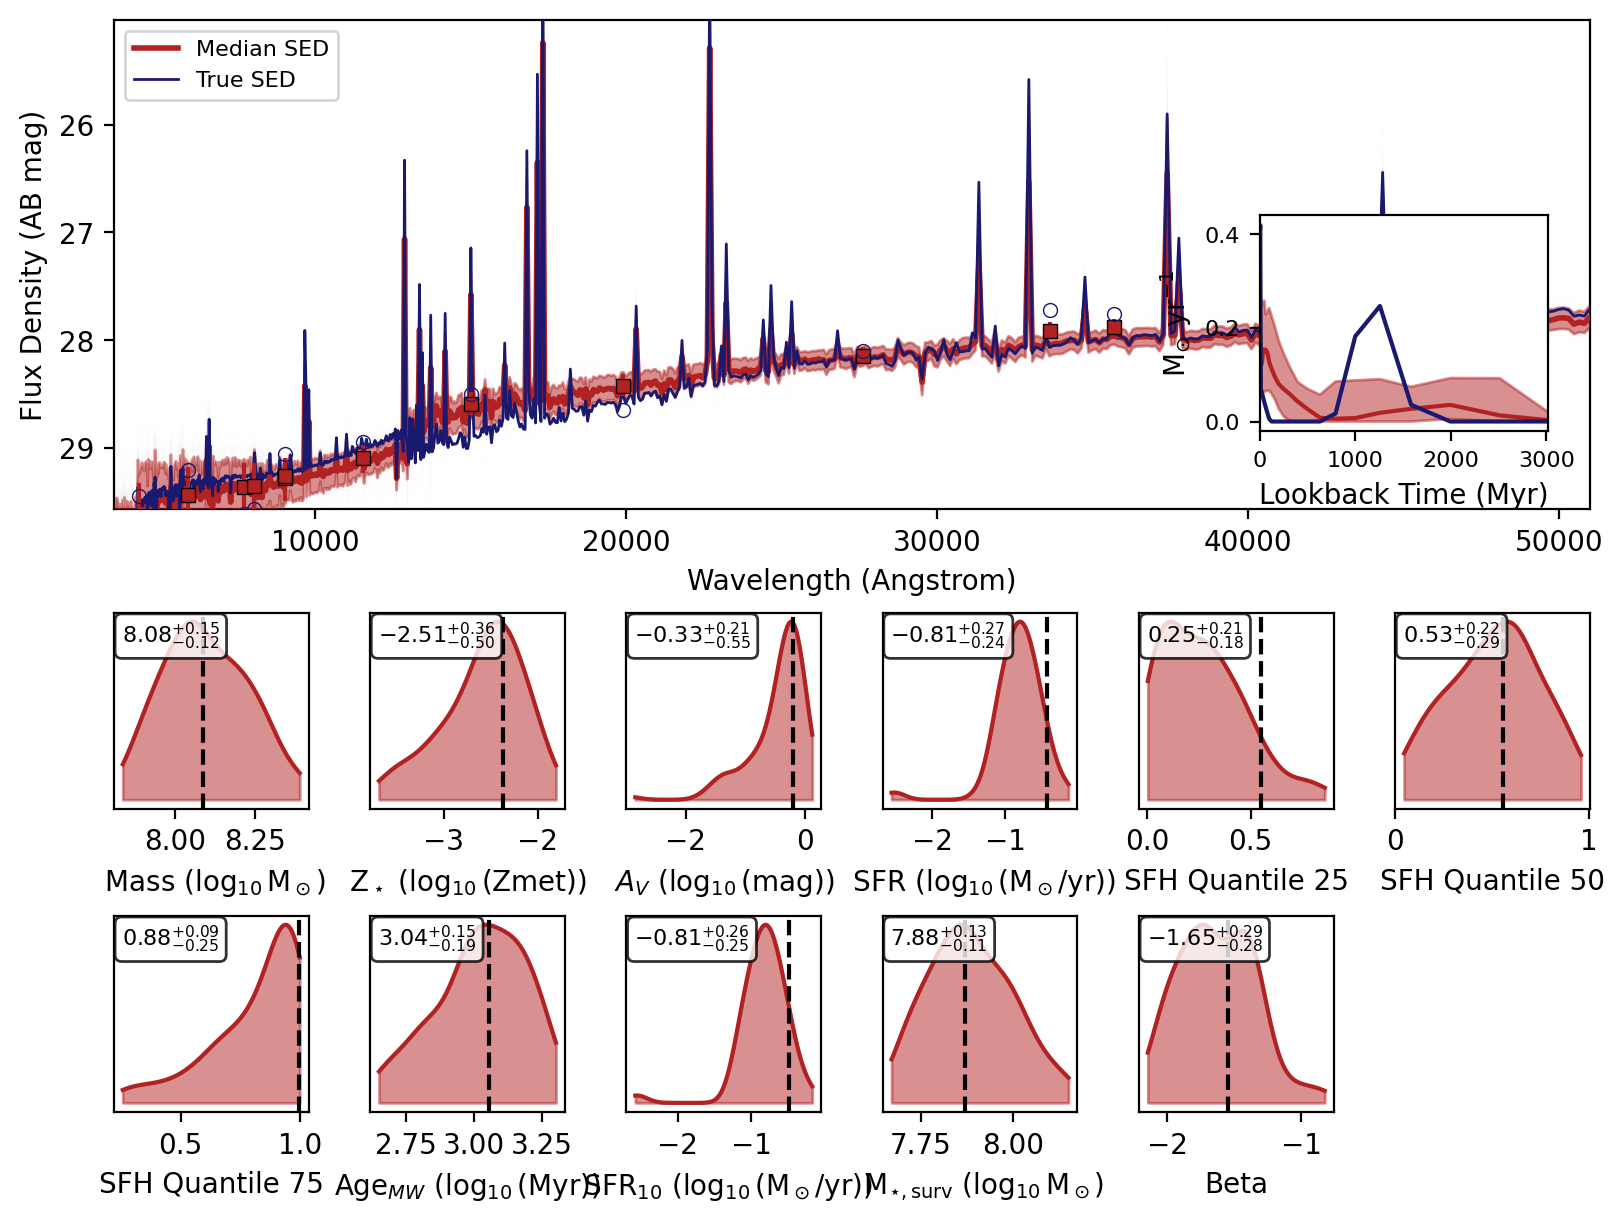

Running simulator on samples: 100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


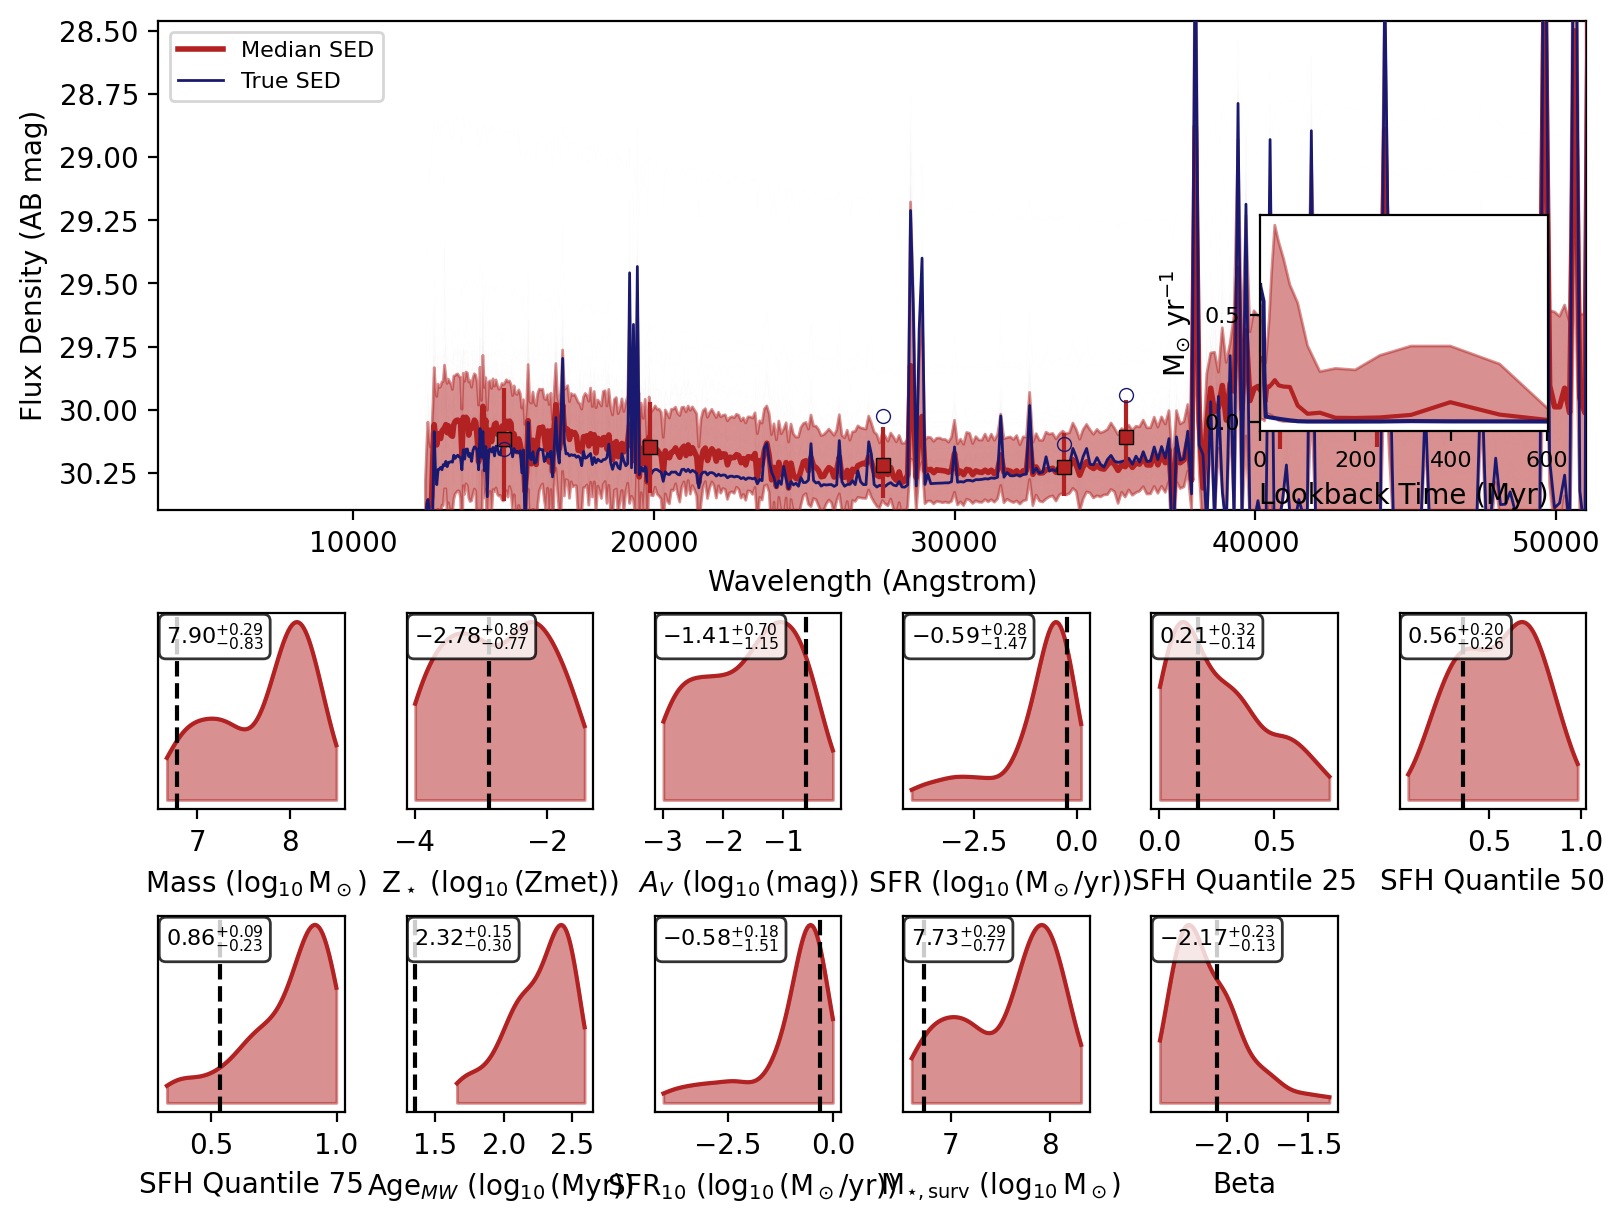

In [12]:
%matplotlib inline

for xi_test, yi_test in zip(X_test, y_test):
    _, _, _, _, fig = fitter.recover_SED(
        X_test=xi_test, true_parameters=yi_test, num_samples=100, save_plots=False
    )

    # jupyter notebook display
    display(fig)